# Transaction Data Gathering
---

Fuente: https://etherscan.io/

Se obtendrá el subgrafo de transacciones construido a partir de un Wallet en un intervalo de tiempo de 1h


## Obtención de números de bloques para las cuentas del dataset


### Importar dataset de cuentas

In [ ]:

import pandas as pd

fraud_df = pd.read_csv('data.csv')
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20302 entries, 0 to 20301
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Address                                              20302 non-null  object 
 1   Flag                                                 20302 non-null  int64  
 2   Avg_min_between_received_tnx                         20302 non-null  float64
 3   Avg_min_between_sent_tnx                             20302 non-null  float64
 4   Sent_tnx                                             20302 non-null  int64  
 5   Received_Tnx                                         20302 non-null  int64  
 6   Number_of_Created_Contracts                          20302 non-null  int64  
 7   Average_of_Unique_Received_From_Addresses            20302 non-null  int64  
 8   Average_of_Unique_Sent_To_Addresses                  20302 non-nul

### Instalar librería *Etherscan* e iniciar API

In [ ]:

!pip install etherscan-python > /dev/null

from etherscan import Etherscan

apiKey = 'EHQQJDT2H93W5QKK3A2YQ1NX3C47AMNMTY'
eth = Etherscan(apiKey)
eth.get_eth_last_price()

{'ethbtc': '0.0552610170053152',
 'ethbtc_timestamp': '1710326143',
 'ethusd': '4046.18201049384',
 'ethusd_timestamp': '1710326141'}

### Obtención de las transacciones realizadas/recibidas por una muestra aleatoria de cuentas del dataset

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

params = {
    'startblock': 0,
    'endblock': 99999999,
    'sort': 'asc'
}

# Obtengo una 5ta parte aleatoria del dataframe
address_list = fraud_df.sample(frac=0.2, random_state=33).reset_index(drop=True)['Address']
tnx_df = pd.DataFrame()
for _, addr in tqdm(address_list.items(), total=len(address_list)):
    tnx = []
    try:
        tnx = eth.get_normal_txs_by_address(address=addr, **params)
    except:
        continue
    new_df = pd.DataFrame(tnx)
    tnx_df = pd.concat([tnx_df, new_df], ignore_index=True)

  0%|          | 0/4060 [00:00<?, ?it/s]

In [ ]:
tnx_df.to_csv('tnx.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp tnx.csv '/content/gdrive/My Drive/Colab Notebooks/'

### Obtención de un intervalo de números de bloque en el que se produzca un pico de transacciones

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive',force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks/'
tnx_df = pd.read_csv('tnx.csv')

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


<ipython-input-5-8c7e8765f819>:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tnx_df = pd.read_csv('tnx.csv')


In [ ]:
tnx_df['blockNumber'] = tnx_df['blockNumber'].astype(int)

<Axes: ylabel='Density'>

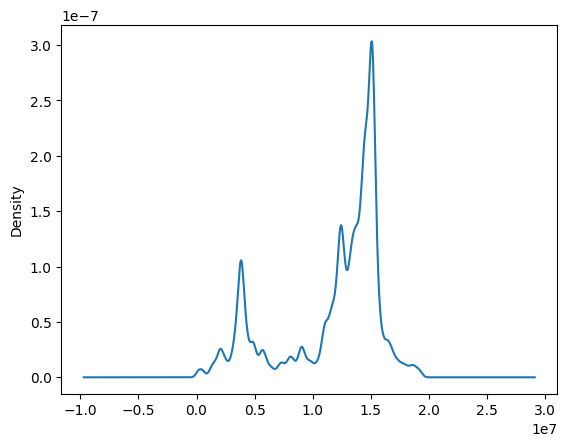

In [ ]:
tnx_df['blockNumber'].plot.kde()

  0%|          | 0/20 [00:00<?, ?it/s]

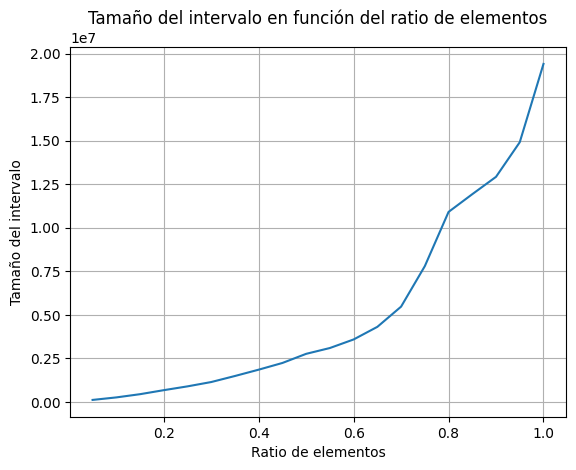

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

def get_smallest_bn_interval(ratio):
    if ratio < 0.01 or ratio > 1:
        return None
    min_len = None
    min_left_bound = None
    min_right_bound = None
    for k in range(int(ratio*100), 101, 1):
        q1 = k/100
        q0 = q1-ratio
        left_bound = int(tnx_df['blockNumber'].quantile(q0))
        right_bound = int(tnx_df['blockNumber'].quantile(q1))
        interval_len = right_bound - left_bound
        if min_len is None or interval_len < min_len:
            min_len = interval_len
            min_left_bound = left_bound
            min_right_bound = right_bound
    return min_left_bound, min_right_bound

ratios = []
sizes = []
for k in tqdm(range(5, 101, 5)):
    q = k/100
    ratios.append(q)
    left_bound, right_bound = get_smallest_bn_interval(q)
    sizes.append(right_bound-left_bound)

plt.plot(ratios, sizes)
plt.xlabel('Ratio de elementos')
plt.ylabel('Tamaño del intervalo')
plt.title('Tamaño del intervalo en función del ratio de elementos')
plt.grid(True)
plt.show()

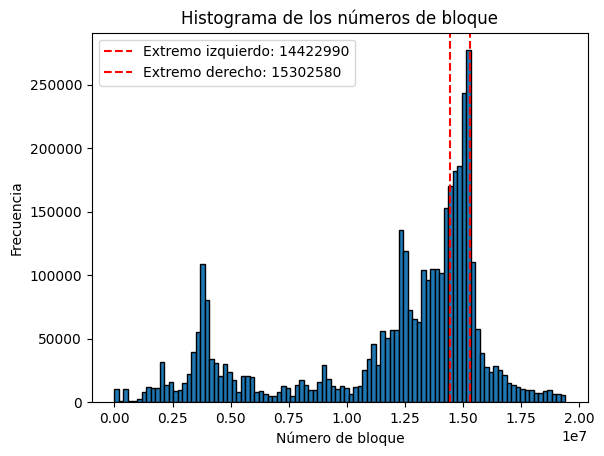

Tamaño del intervalo: 879,590


In [ ]:
left_bn, right_bn = get_smallest_bn_interval(0.25)

freq, bins, _ = plt.hist(tnx_df['blockNumber'], bins=100, edgecolor='black')
plt.axvline(x=left_bn, color='red', linestyle='--', label=f'Extremo izquierdo: {left_bn}')
plt.axvline(x=right_bn, color='red', linestyle='--', label=f'Extremo derecho: {right_bn}')
plt.xlabel('Número de bloque')
plt.ylabel('Frecuencia')
plt.title('Histograma de los números de bloque')
plt.legend()
plt.show()
print(f'Tamaño del intervalo: {(right_bn - left_bn):,}')